In [1]:
import numpy as np
import sympy as sp
from scipy.integrate import nquad,quad
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def generate_basis(method,begin,end,n):
    x = sp.Symbol('x')
    basis_list = []
    if method == 'linear':
        skip = (end-begin)/n
        for i in tqdm(range(n+1)):
            temp_begin = begin+(i-1)*skip
            temp_end = temp_begin+2*skip
            basis_list.append(sp.Piecewise((0, x < temp_begin),(0, x > temp_end),(1-sp.Abs(x-temp_begin-skip)/skip, True)))
    if method == 'trigo':
        feature = 2*sp.pi/(end-begin)
        for i in tqdm(range(n+1)):
            basis_list.append(sp.cos(i*feature*x))
        for i in tqdm(range(1,n+1)):
            basis_list.append(sp.sin(i*feature*x))
    return basis_list

In [3]:
def construct_A(n,basis_list):
    matrix_A = sp.zeros(n+1)
    pos = []
    for p in range(0, n+1):
        for q in range(0, n+1):
            pos.append([p,q])
    for item in tqdm(pos):
        matrix_A = create_value(matrix_A,item,basis_list)
    return matrix_A

In [4]:
def create_value(matrix_A,pos,basis_list):
    fi = basis_list[pos[0]]
    fj = basis_list[pos[1]]
    n_y = K*fi.subs(x,y)*fj
#     print(n_y)
    n_y_numpy = sp.lambdify((x,y),n_y,'numpy')
    #n_result = n_taylor_x.integrate((x,begin,end))
    options={'limit':100}
    n_result,_ = nquad(n_y_numpy,[[begin,end],[begin,end]], opts = [options,options])
    matrix_A[pos[0],pos[1]] = n_result
    return matrix_A

In [5]:
def Galerkin_method(n):
    basis_list = generate_basis(method,begin,end,n)
    if method == 'linear':
        m = n
        h = (end - begin)/n
        Gamma = np.zeros((n+1,n+1))
        Gamma = Gamma+ np.diag(np.ones(n+1)*2*h/3,0)
        temp = np.diag(np.ones(n)*h/6,1)
        Gamma = Gamma+temp+temp.T
        Gamma[0,0] = Gamma[0,0]-h/3
        Gamma[n,n] = Gamma[n,n]-h/3
        Lambda_diag = Lambda*Gamma
    elif method == 'trigo':
        m = 2*n
        Gamma = np.zeros((2*n+1,2*n+1))
        Gamma = Gamma+np.diag(np.ones(2*n+1)*(end-begin)/2)
        Gamma[0,0] = end-begin
        Lambda_diag = Lambda*Gamma
    K_matrix = construct_A(m,basis_list)
    A_n = Lambda_diag-K_matrix
    # 计算得到 c
    y_ = sp.zeros(m+1,1)
    for i in tqdm(range(m+1)):
        g_mod = g * basis_list[i]
        g_mod_numpy = sp.lambdify(x,g_mod,'numpy')
        result,_ = quad(g_mod_numpy,begin,end)
        y_[i, 0] = result
        
    A_n_acce = np.matrix(A_n).astype(np.float64)
    A_n_acce_inv = A_n_acce**(-1)
    A_n_inv = sp.Matrix(A_n_acce_inv)
    c = A_n_inv*y_
    result = 0
    for i in range(m+1):
        result = result + basis_list[i]*c[i,0]
    return result

In [6]:
x = sp.Symbol('x')
y = sp.Symbol('y')
Lambda = 1   
K =sp.exp( x*y)
begin = 0
end = 1
f_origin = 1+5*x+sp.exp(x)
method = 'trigo'
# 作图可调整参数
start = 6
total = 6
span = 2

In [7]:
g = Lambda*f_origin-(K*f_origin.subs(x,y)).integrate((y,begin,end))
print(f'calculate g')
g

calculate g


5*x - Piecewise((7 - 11*exp(-1), Eq(x, -1)), (5/2 + E, Eq(x, 0)), (E*x**2*exp(x)/(x**3 + x**2) + 6*x**2*exp(x)/(x**3 + x**2) - 2*x**2/(x**3 + x**2) + x*exp(x)/(x**3 + x**2) + 4*x/(x**3 + x**2) - 5*exp(x)/(x**3 + x**2) + 5/(x**3 + x**2), True)) + exp(x) + 1

正在处理n=6的情况：


100%|██████████| 13/13 [00:00<00:00, 168.35it/s]


正在处理n=8的情况：


100%|██████████| 17/17 [00:00<00:00, 176.01it/s]


正在处理n=10的情况：


100%|██████████| 21/21 [00:00<00:00, 154.62it/s]


正在处理n=12的情况：


100%|██████████| 25/25 [00:00<00:00, 144.40it/s]


正在处理n=14的情况：


100%|██████████| 29/29 [00:00<00:00, 133.76it/s]


正在处理n=16的情况：


100%|██████████| 33/33 [00:00<00:00, 128.23it/s]


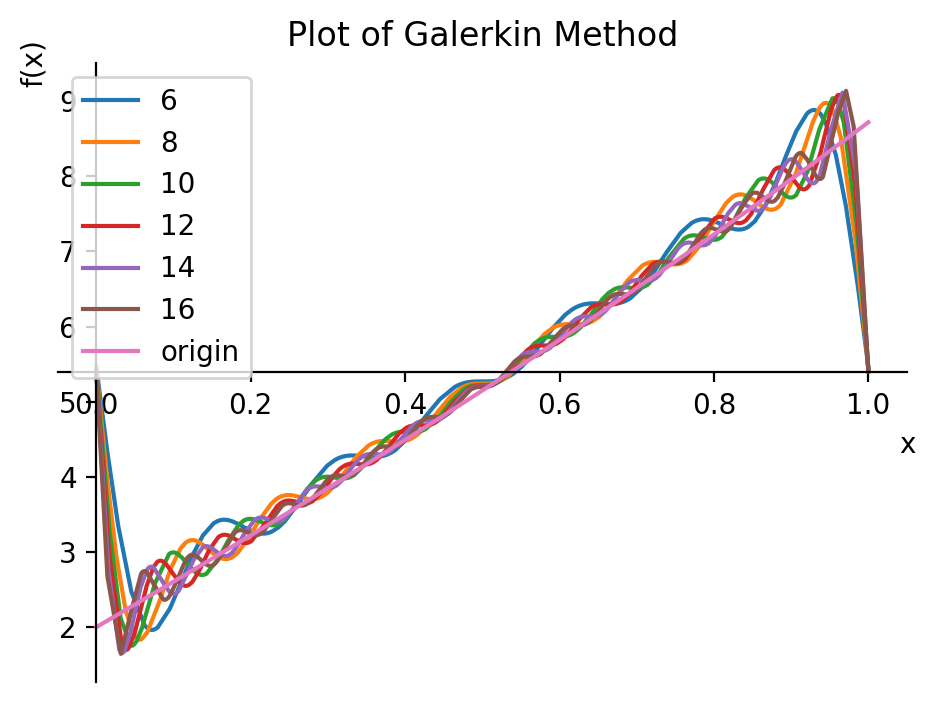

In [8]:
err_all = []
for i in range(start,start+total*span,span):
    print(f'正在处理n={i}的情况：')
    result = Galerkin_method(i)
    err_func = sp.lambdify(x,(result-f_origin)**2,'numpy')
    err = quad(err_func,begin,end,limit=max(i,100))[0]
    err_all.append(err/(end-begin))
    if i==start:
        p = sp.plotting.plot(result,(x,begin,end),show=False,label=str(i),legend=True,title='Plot of Galerkin Method')
    else:
        p.append(sp.plotting.plot(result,(x,begin,end),show=False,label=str(i))[0])
p.append(sp.plotting.plot(f_origin,(x,begin,end),show=False,label='origin')[0])
p.show()

[0.36518878345162675, 0.27696472365431263, 0.22302865140260883, 0.1866589079299329, 0.16048057788854597, 0.14073838886332768]


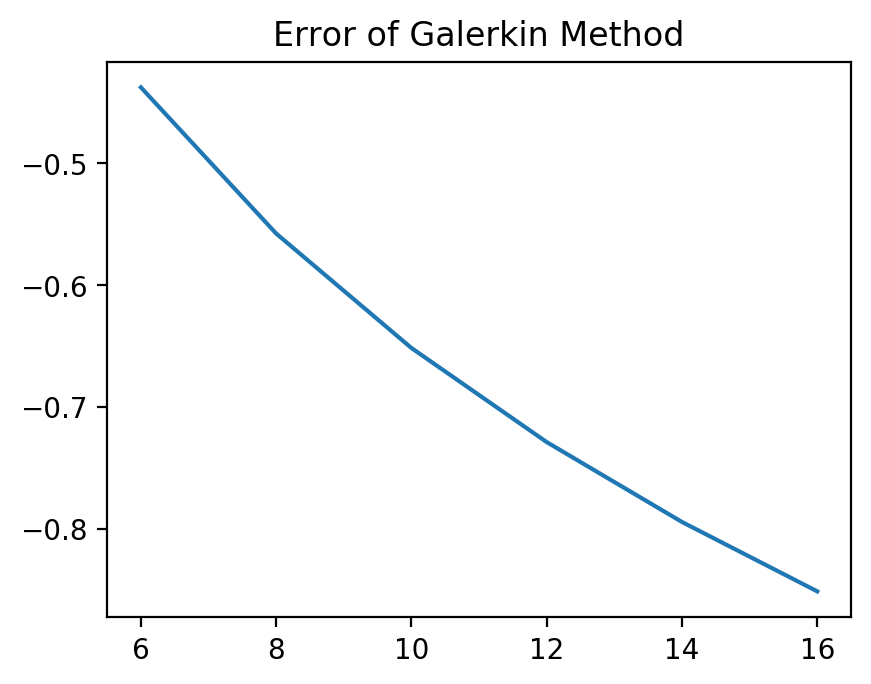

In [9]:
p_err = plt.plot(np.arange(start,start+span*total,span),[np.log10(float(x)) for x in err_all])
plt.title('Error of Galerkin Method')
print(err_all)